# SONG POPULARITY PREDICTION & CONTENT BASED RECOMMENDER SYSTEM

In [29]:
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

In [30]:
import plotly.express as px

# 2. DATA COLLECTION

In [31]:
# Link for Dataset: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset
# Import the dataset
df1 = pd.read_csv("/content/sample_data/music.csv")
df1.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# 3. DATA EXPLORATION, CLEANING & PREPROCESSING

In [32]:
count_na_percent =(df1.isna().sum()/len(df1))*100 #percentage of NAN in the dataset for each varible
count_na_percent

Unnamed: 0          0.000000
track_id            0.000000
artists             0.000877
album_name          0.000877
track_name          0.000877
popularity          0.000000
duration_ms         0.000000
explicit            0.000000
danceability        0.000000
energy              0.000000
key                 0.000000
loudness            0.000000
mode                0.000000
speechiness         0.000000
acousticness        0.000000
instrumentalness    0.000000
liveness            0.000000
valence             0.000000
tempo               0.000000
time_signature      0.000000
track_genre         0.000000
dtype: float64

In [33]:
df1 = df1.dropna() # drop NaN

In [34]:
# Dropping Unnamed column as it is duplicate of Index #
df2= df1.drop("Unnamed: 0",axis=1)
df2.explicit.replace({True: 1, False: 0}, inplace= True)

In [35]:
# Dropping Duplicate instances
df3 = df2.drop_duplicates(subset=['album_name']).reset_index(drop=True)

Text(0.5, 1.0, 'Hisogram plot')

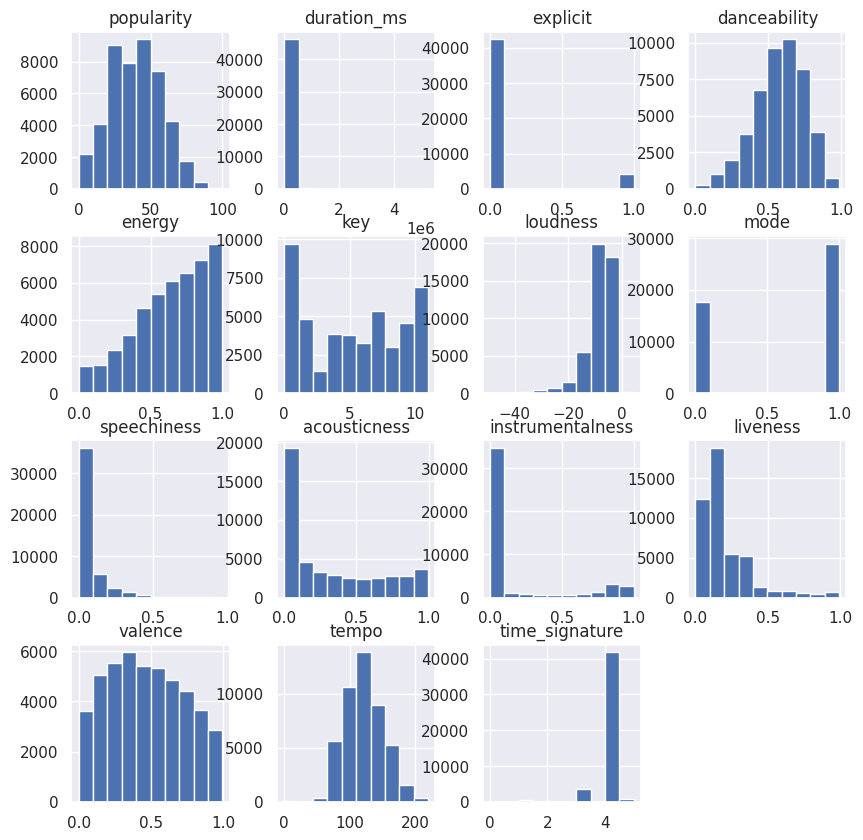

In [36]:
df3.hist(figsize=(10,10))
plt.title("Hisogram plot", size=15, weight='bold')

<ipython-input-37-c740403500e0>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

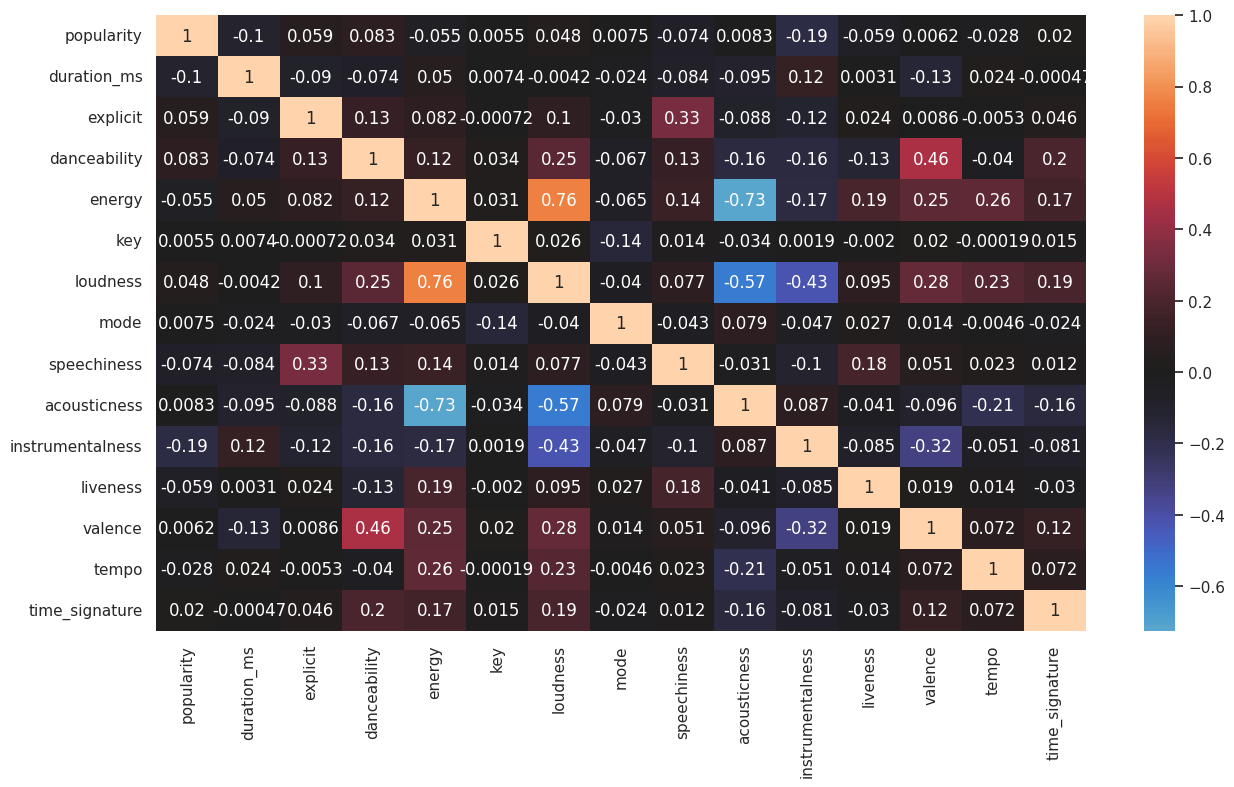

In [37]:
# Correlation/ Heatmap- Pearson's Coefficients
corr = df3.corr()
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.heatmap(corr, annot = True, center=0, ax = ax)

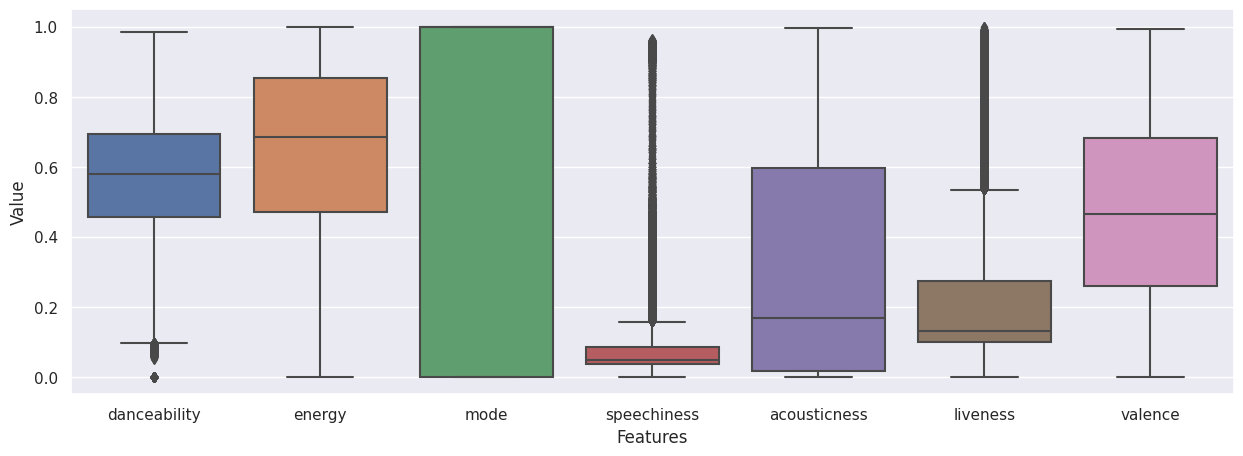

In [38]:
# Boxplots showing the Outliers
plt.figure(figsize=(15,5))
sns.boxplot(data=df2.drop(['track_id', 'artists', 'track_name','duration_ms','popularity','explicit', 'instrumentalness', 'tempo', 'time_signature', 'loudness','key'], axis=1))
plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

In [39]:
# TOP 5 albums from each genre
df4=df3.groupby(['track_genre','popularity','album_name']).agg(pop=('popularity','sum')).reset_index()
df5=df4.sort_values(by=['track_genre','popularity'], ascending=True).groupby(['track_genre']).tail(5)

fig=px.treemap(df5, path=["track_genre", 'album_name'], values='pop', color='track_genre')
fig.update_layout(title_text='Top 5 albums from each genre', margin = dict(t=10, l=10, r=10, b=10))
fig.show()

In [40]:
# Top 5 tracks in terms of its popularity
df_top_tracks=df3.sort_values(by='popularity',ascending=False).head(10).reset_index(drop=True)
df_top_tracks.index=df_top_tracks.index + 1
df_top_tracks.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
1,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,0,0.714,0.472,2,-7.375,1,0.0864,0.01300,0.000005,0.2660,0.238,131.121,4,dance
2,2tTmW7RDtMQtBk7m2rYeSw,Bizarrap;Quevedo,"Quevedo: Bzrp Music Sessions, Vol. 52","Quevedo: Bzrp Music Sessions, Vol. 52",99,198937,0,0.621,0.782,2,-5.548,1,0.0440,0.01250,0.033000,0.2300,0.550,128.033,4,hip-hop
3,4uUG5RXrOk84mYEfFvj3cK,David Guetta;Bebe Rexha,I'm Good (Blue),I'm Good (Blue),98,175238,1,0.561,0.965,7,-3.673,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,4,dance
4,5ww2BF9slyYgNOk37BlC4u,Manuel Turizo,La Bachata,La Bachata,98,162637,0,0.835,0.679,7,-5.329,0,0.0364,0.58300,0.000002,0.2180,0.850,124.980,4,latin
5,6Sq7ltF9Qa7SNFBsV5Cogx,Bad Bunny;Chencho Corleone,Un Verano Sin Ti,Me Porto Bonito,97,178567,1,0.911,0.712,1,-5.105,0,0.0817,0.09010,0.000027,0.0933,0.425,92.005,4,latin


In [41]:
# Artists with higher number of contents in the spotify dataset
df3['Count']=1
df_artist=df3.groupby('artists')['Count'].sum().reset_index().sort_values(by='Count',ascending=False)

In [42]:
df_artist

,artists,Count
23359,Vybz Kartel,73
20775,Sujatha,71
8244,George Jones,69
19394,Scooter,55
15914,Nogizaka46,49
...,...,...
9784,Inner City;ZebrA OctobrA,1
9783,"Inner City;Steve ""Silk"" Hurley",1
9781,Inner City;Serial Diva,1
9780,Inner City;Pique;Darksiight,1


# 4. DIMENSION REDUCTION

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

In [44]:
# Standardizing Data before implementing PCA
scaler = StandardScaler() 
df5=pd.DataFrame(scaler.fit_transform(df2.iloc[:, 4:18]))

In [45]:
# Finding Cumulative Proportion of Variance
pca = decomposition.PCA ()
pca.fit(df5)
df5_transformed=pca.transform(df5)
explained_variance = pca.explained_variance_
proportion_variance = pca.explained_variance_ratio_
cummulative_proportion_of_variance = pca.explained_variance_ratio_.cumsum()
x = []
x.append(proportion_variance)
#print("\n Explained variance : \n", explained_variance)
#print("\n Proportion_variance : \n", proportion_variance)
#print("\n cummulative proportion of variance : \n", cummulative_proportion_of_variance)

In [46]:
pca_df5_Standard=pd.DataFrame(data = df5_transformed)
a= pca_df5_Standard[pca_df5_Standard.columns[0:2]]

In [47]:
# Dropping loudness as its correlated highly with energy
df7= df3.drop(['loudness'], axis=1)

#DATA PARTITIONING

In [48]:
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import linear_model, tree
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import random
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from joblib import Parallel, delayed
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [49]:
# Creating Dummies for categorical variables key and mode
cat_var= ['key', 'mode']
df8 = pd.get_dummies(df7, columns=cat_var)

In [50]:
data= df8.iloc[:, [4,18,19,20,21,22,23,24,25,26,27,28,29,30,31]]
data.head()

,popularity,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1
0,73,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,55,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,57,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,71,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,82,0,0,1,0,0,0,0,0,0,0,0,0,0,1


CHI SQUARE TEST FOR INDEPENDENCE

In [51]:
from scipy.stats import chi2_contingency
# get the list of column names in the dataframe
cols_to_drop = []
columns = data.columns.tolist()

# loop over class vs all other pairs of columns
for j in range(len(columns)):
        # create a contingency table of the two variables
        contingency_table = pd.crosstab(data["popularity"], data[columns[j]])
        
        # perform the chi-square test and print the p-value
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        if p>0.05:
          print(f"Chi-square test between popularity and{columns[j]}: p-value = {p}")
          cols_to_drop.append(columns[j])
        else:
           print(f"Keep the variables  {columns[j]}")

data1 = data.drop(cols_to_drop, axis=1)

Keep the variables  popularity
Chi-square test between popularity andkey_0: p-value = 0.09678776852201883
Keep the variables  key_1
Keep the variables  key_2
Chi-square test between popularity andkey_3: p-value = 0.7471691077545126
Chi-square test between popularity andkey_4: p-value = 0.3817328248622765
Chi-square test between popularity andkey_5: p-value = 0.4063038450802793
Keep the variables  key_6
Keep the variables  key_7
Keep the variables  key_8
Chi-square test between popularity andkey_9: p-value = 0.06161432234943596
Keep the variables  key_10
Chi-square test between popularity andkey_11: p-value = 0.3006893177021598
Keep the variables  mode_0
Keep the variables  mode_1


In [52]:
df_new= df8.drop(df8.columns[[4,18,19,20,21,22,23,24,25,26,27,28,29,30,31]], axis=1)

In [53]:
df8 = pd.concat([df_new, data1], axis=1)
df8.head()

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Count,popularity,key_1,key_2,key_6,key_7,key_8,key_10,mode_0,mode_1
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,230666,0,0.676,0.4610,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,1,73,1,0,0,0,0,0,1,0
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,149610,0,0.420,0.1660,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,1,55,1,0,0,0,0,0,0,1
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,210826,0,0.438,0.3590,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,1,57,0,0,0,0,0,0,0,1
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,201933,0,0.266,0.0596,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,1,71,0,0,0,0,0,0,0,1
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,198853,0,0.618,0.4430,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,1,82,0,1,0,0,0,0,0,1


In [54]:
pd.options.display.max_columns = None

In [55]:
features = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness","key_1", 
            "key_2", "key_6", "key_7",
            "key_8", "key_10", "liveness", 
            "mode_0","mode_1", "speechiness", "tempo", "valence"]

In [56]:
X = df8[features]
y = df8['popularity']

#DATA MODELLING & MODEL PERFORMANCE EVALUATION

**REGRESSION MODELS**

In [58]:
# Splitting Data to Train and Test Data.. 80% for Training and 20% for Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [59]:
# Implementing regression models
XGBreg = XGBRegressor(scale_pos_weight=1,learning_rate=0.01, colsample_bytree = 0.3, subsample = 0.8, n_estimators=1000, 
                      reg_alpha = 0.3, max_depth=10, gamma=1)
ridge_model = linear_model.Ridge(alpha=.5)
lasso_model = linear_model.Lasso(alpha =.1)
tr = tree.DecisionTreeRegressor()
bayridge_model = linear_model.BayesianRidge()
lm = linear_model.LinearRegression()
poly_list = [PolynomialFeatures(degree=i, include_bias=False) for i in range(2,4)]
prm_list = [linear_model.LinearRegression() for i in range(2,4)]

In [60]:
# Performance Evaluation of Models
def model_metrics(model, X_test, y_test, decimals = 5, X_train = X_train, y_train = y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = np.round(mean_squared_error(y_test, y_pred),decimals)
    rmse= np.round(np.sqrt(mse),decimals)
    r2 = np.round(r2_score(y_test, y_pred),decimals)
    return {'mean_squared_error': mse, 'R-Squared': r2}

In [61]:
# Performance Evaluation of Polynomial Models
def poly_model_metrics(models, poly_list, X_test, y_test, decimals = 5, X_train = X_train, y_train = y_train):
    metrics_list = []
    for i in range(len(models)):
        poly_features = poly_list[i].fit_transform(X_train)
        models[i].fit(poly_features, y_train)
        y_pred = models[i].predict(poly_list[i].fit_transform(X_test))
        mse = np.round(mean_squared_error(y_test, y_pred), decimals)
        rmse= np.round(np.sqrt(mse),decimals)
        r2 = np.round(r2_score(y_test, y_pred), decimals)
        metrics_list.append(
            {'mean_squared_error': mse, 'R-Squared': r2})
    return metrics_list

In [62]:
poly_models = poly_model_metrics(prm_list, poly_list, X_test, y_test)
poly_results = pd.DataFrame(
    [
        {'mean_squared_error': metrics['mean_squared_error'], 'R-Squared': metrics['R-Squared']} 
        for metrics in poly_models
    ],
    index = [f'PolynomiyalRegression_{i+2}_degrees' for i in range(len(poly_models))]) \
.reset_index() \
.rename(columns = {'index': 'model'})

In [63]:
# Performance Results for each regression models
results = pd.DataFrame(
    [
        model_metrics(XGBreg, X_test, y_test),
        model_metrics(ridge_model, X_test, y_test),
        model_metrics(lasso_model, X_test, y_test),
        model_metrics(tr, X_test, y_test),
        model_metrics(bayridge_model, X_test, y_test),
        model_metrics(lm, X_test, y_test)
    ], 
    index = ['XGBRegressor', 'Ridge', 'Lasso', 'DecisionTreeRegressor', 'BayesianRidge', 'LinearRegression']) \
.reset_index() \
.rename(columns={'index':'model'})

In [64]:
results = results.append(poly_results)

<ipython-input-64-ed0a3de5efb5>:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [65]:
results.sort_values(['mean_squared_error', 'R-Squared'],
              ascending = [True, False])

,model,mean_squared_error,R-Squared
0,XGBRegressor,270.42273,0.17320
0,PolynomiyalRegression_2_degrees,295.66306,0.09603
5,LinearRegression,304.13721,0.07013
1,Ridge,304.13744,0.07013
4,BayesianRidge,304.14244,0.07011
2,Lasso,306.36421,0.06332
1,PolynomiyalRegression_3_degrees,326.71765,0.00109
3,DecisionTreeRegressor,534.30825,-0.63360


In [66]:
y_pred = XGBreg.predict(X_test)

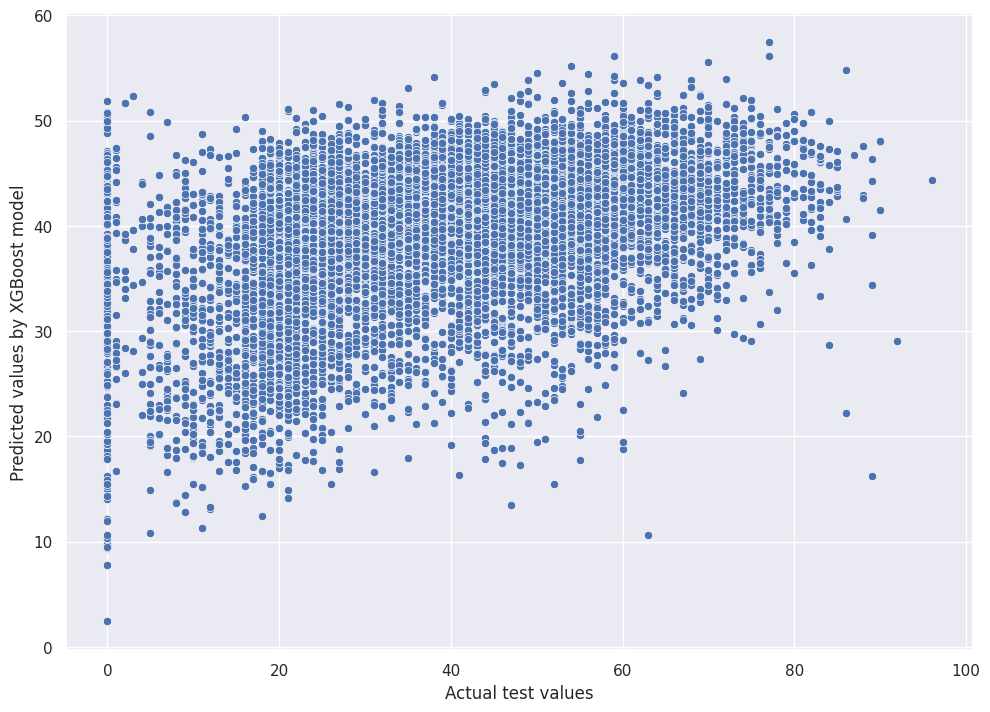

In [67]:
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='Actual test values', ylabel='Predicted values by XGBoost model')
plt.show()

In [68]:
xgb_model = XGBreg.fit(X_train, y_train)

In [69]:
xgb_ftr_imp = xgb_model.feature_importances_

In [70]:
# Computing feature importances.
pd.DataFrame({'feature':features, 'importance':xgb_ftr_imp}).sort_values(by='importance', ascending=False)

,feature,importance
4,instrumentalness,0.089735
0,acousticness,0.076559
15,tempo,0.076087
16,valence,0.074726
2,duration_ms,0.074079
3,energy,0.072343
14,speechiness,0.070157
1,danceability,0.063290
11,liveness,0.062798
13,mode_1,0.047782


**Regression Models didn't give good results. The best regression model (XGBooster) provided R^2 of 17% which is too low
As next step, we will bin popularity variable as Top, Average and Bottom and use classification algorithms for modelling. Our Plan is to use KNN and Decision Tree Classifier for modelling and try to predict "TOP" songs which will be among listoner's favorite**

**CLASSIFICATION MODELS**

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics

In [72]:
# Binning Popularity into 3 Bins- Bottom, Average, top
pd.cut(df8['popularity'], bins=3)

0         (66.667, 100.0]
1        (33.333, 66.667]
2        (33.333, 66.667]
3         (66.667, 100.0]
4         (66.667, 100.0]
               ...       
46584    (33.333, 66.667]
46585      (-0.1, 33.333]
46586      (-0.1, 33.333]
46587      (-0.1, 33.333]
46588    (33.333, 66.667]
Name: popularity, Length: 46589, dtype: category
Categories (3, interval[float64, right]): [(-0.1, 33.333] < (33.333, 66.667] < (66.667, 100.0]]

In [73]:
pd.cut(df8['popularity'], bins=3, labels = ["Bottom", "Average", "Top"]).value_counts()

Average    25240
Bottom     18223
Top         3126
Name: popularity, dtype: int64

In [74]:
df8['popularity'] = pd.cut(df8.popularity, bins=3, labels = ["Bottom", "Average", "Top"], right = True)

In [75]:
df8.head()

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Count,popularity,key_1,key_2,key_6,key_7,key_8,key_10,mode_0,mode_1
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,230666,0,0.676,0.4610,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,1,Top,1,0,0,0,0,0,1,0
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,149610,0,0.420,0.1660,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,1,Average,1,0,0,0,0,0,0,1
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,210826,0,0.438,0.3590,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,1,Average,0,0,0,0,0,0,0,1
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,201933,0,0.266,0.0596,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,1,Top,0,0,0,0,0,0,0,1
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,198853,0,0.618,0.4430,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,1,Top,0,1,0,0,0,0,0,1


In [76]:
df8.loc[df8['popularity']== 'Top'].head()

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Count,popularity,key_1,key_2,key_6,key_7,key_8,key_10,mode_0,mode_1
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,230666,0,0.676,0.4610,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,1,Top,1,0,0,0,0,0,1,0
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,201933,0,0.266,0.0596,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,1,Top,0,0,0,0,0,0,0,1
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,198853,0,0.618,0.4430,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,1,Top,0,1,0,0,0,0,0,1
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,229400,0,0.407,0.1470,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic,1,Top,0,1,0,0,0,0,0,1
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,242946,0,0.703,0.4440,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic,1,Top,0,0,0,0,0,0,0,1


In [77]:
X = df8[features]
y = df8['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [78]:
scaler = StandardScaler()

# fit the StandardScaler on the training data
scaler.fit(X_train)

# transform the training and testing data using the fitted StandardScaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
!pip install --upgrade imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [82]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print(X_ros.shape, y_ros.shape)

(60627, 17) (60627,)


**LOGISTIC REGRESSION**

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

# random search logistic regression model on the sonar dataset
from scipy.stats import loguniform
from sklearn.metrics import classification_report
model = LogisticRegression(random_state=0).fit(X_train, y_train)
pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

0.4589312221672439
              precision    recall  f1-score   support

     Average       0.41      0.25      0.31      4089
      Bottom       0.49      0.47      0.48      3979
         Top       0.46      0.65      0.54      4058

    accuracy                           0.46     12126
   macro avg       0.45      0.46      0.44     12126
weighted avg       0.45      0.46      0.44     12126



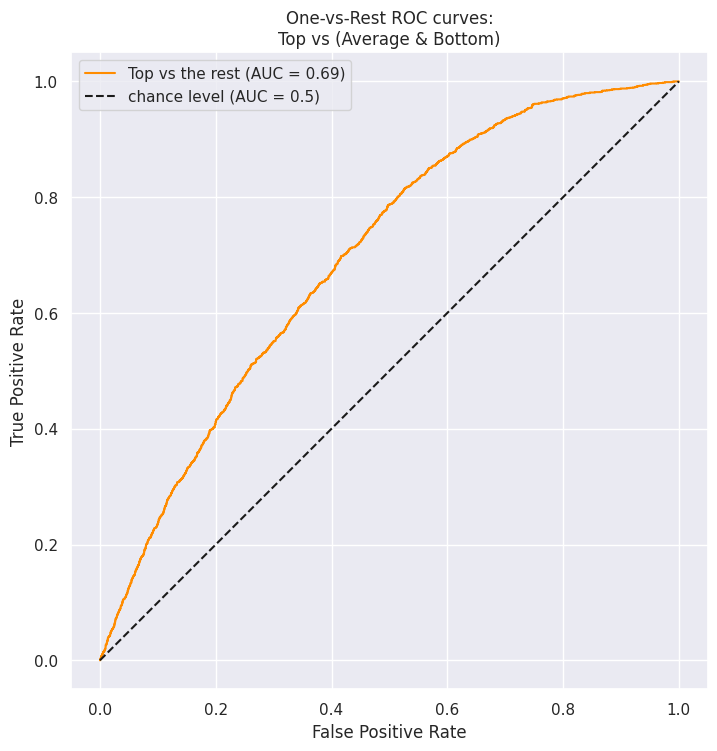

In [85]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

label_binarizer.transform(["Top"])

class_of_interest = "Top"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

y_score = LogisticRegression(random_state=0).fit(X_train, y_train).predict_proba(X_test)

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nTop vs (Average & Bottom)")
plt.legend()
plt.show()

**KNN CLASSIFIER**

In [86]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [87]:
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.7673593930397493


In [88]:
from sklearn.model_selection import RandomizedSearchCV
k_range2 = range(1, 22)
param_dist = dict(n_neighbors=k_range2)

In [89]:
rand = RandomizedSearchCV(knn, param_dist, cv=5, scoring='accuracy', n_iter=5, random_state=5)

In [90]:
rand.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=1),
                   n_iter=5, param_distributions={'n_neighbors': range(1, 22)},
                   random_state=5, scoring='accuracy')

In [91]:
rand.cv_results_

{'mean_fit_time': array([0.04364324, 0.04511018, 0.04278865, 0.04246378, 0.0435544 ]),
 'std_fit_time': array([0.01193294, 0.01814797, 0.01308718, 0.01264746, 0.01202934]),
 'mean_score_time': array([2.66178803, 2.66198635, 2.66010218, 2.66333599, 2.65941267]),
 'std_score_time': array([0.48171863, 0.40314022, 0.35739959, 0.31908522, 0.34606935]),
 'param_n_neighbors': masked_array(data=[3, 18, 20, 21, 19],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3},
  {'n_neighbors': 18},
  {'n_neighbors': 20},
  {'n_neighbors': 21},
  {'n_neighbors': 19}],
 'split0_test_score': array([0.68848572, 0.55076796, 0.54654159, 0.54458303, 0.55025255]),
 'split1_test_score': array([0.68175258, 0.54041237, 0.53886598, 0.53948454, 0.53865979]),
 'split2_test_score': array([0.68206186, 0.54175258, 0.53845361, 0.5385567 , 0.54123711]),
 'split3_test_score': array([0.68628866, 0.54298969, 0.53536082, 0.53628866, 0.5423

In [92]:
# examining the best model
print(rand.best_score_) #single best score achieved across all params 
print(rand.best_params_) #Dictionary containing the parameters (k) used to generate that score
print(rand.best_estimator_) #estimator which gave the highest score 

0.6859651858613789
{'n_neighbors': 3}
KNeighborsClassifier(n_neighbors=3)


In [93]:
# Fit KNN model on resampled data
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predict on test data
y_pred = knn.predict(X_test)

# Evaluate accuracy
print(metrics.accuracy_score(y_test, y_pred))

0.7031997361042388


In [94]:
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

     Average       0.63      0.52      0.57      4089
      Bottom       0.65      0.60      0.62      3979
         Top       0.79      0.99      0.88      4058

    accuracy                           0.70     12126
   macro avg       0.69      0.70      0.69     12126
weighted avg       0.69      0.70      0.69     12126



In [95]:
cmat = confusion_matrix(y_test, y_pred)

In [96]:
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - Flase Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TP - True Positive {}'.format(cmat[1,1]))
print('Accuracy Score: {}'.format(np.divide(np.sum([cmat[0,0], cmat[1,1], cmat[2,2]]), np.sum(cmat)))) 
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[1,0], cmat[0,1], cmat[0,2], cmat[2,0], cmat[1,2], cmat[2,1]]), np.sum(cmat))))

TP - True Negative 2120
FP - Flase Positive 1261
FN - False Negative 1231
TP - True Positive 2381
Accuracy Score: 0.7031997361042388
Misclassification Rate: 0.2968002638957612


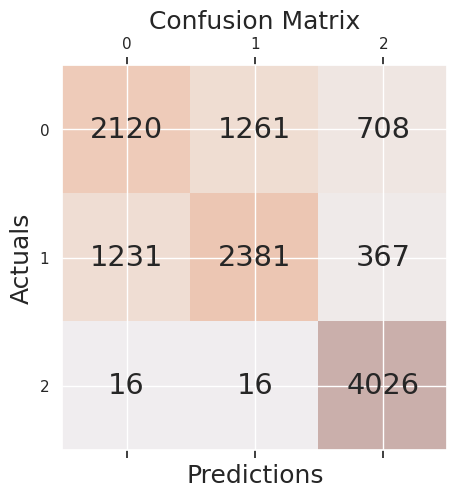

In [97]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cmat, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cmat.shape[0]):
    for j in range(cmat.shape[1]):
        ax.text(x=j, y=i,s=cmat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [98]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(12126, 3)

In [99]:
label_binarizer.transform(["Top"])

array([[0, 0, 1]])

In [100]:
class_of_interest = "Top"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

2

In [101]:
y_score = knn.fit(X_train, y_train).predict_proba(X_test)

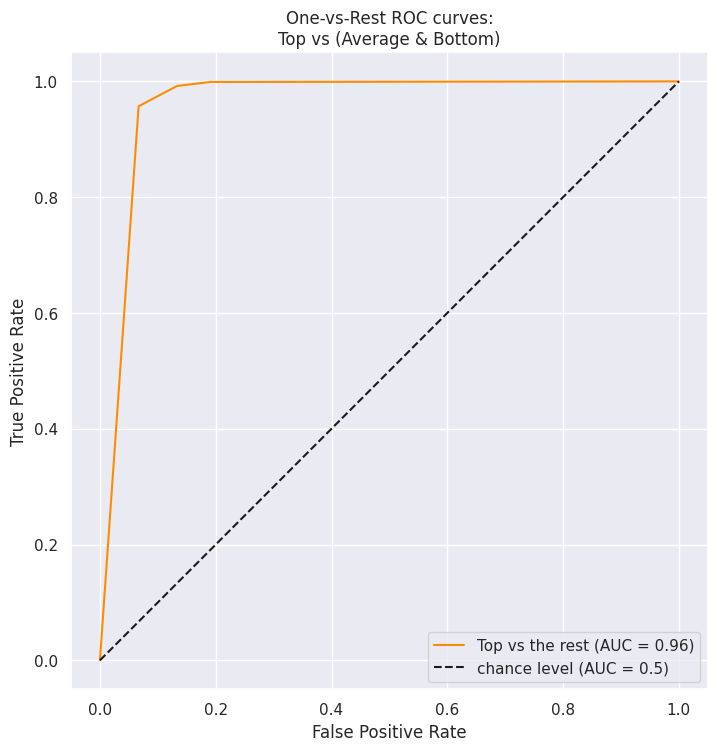

In [102]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nTop vs (Average & Bottom)")
plt.legend()
plt.show()

**DECISION TREE CLASSIFIER**

In [103]:
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

In [104]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
classifier = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
classifier_cv = RandomizedSearchCV(classifier, param_dist, cv=5)

# Fit it to the data
classifier_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(classifier_cv.best_params_))
print("Best score is {}".format(classifier_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 2}
Best score is 0.6954908039026692


In [105]:
classifier = DecisionTreeClassifier(criterion= 'gini', max_depth=None, max_features=8, min_samples_leaf= 3)
classifier.fit(X_train, y_train)
y_pred_class = classifier.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.7349496948705262


In [106]:
y_pred_class = classifier.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.7349496948705262


In [107]:
cmat = confusion_matrix(y_test, y_pred_class)

In [108]:
print(classification_report(y_test,y_pred_class))

              precision    recall  f1-score   support

     Average       0.66      0.58      0.61      4089
      Bottom       0.67      0.64      0.65      3979
         Top       0.85      0.99      0.91      4058

    accuracy                           0.73     12126
   macro avg       0.72      0.73      0.73     12126
weighted avg       0.72      0.73      0.73     12126



In [109]:
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - Flase Positive {}'.format(cmat[0,2]))
print('FN - False Negative {}'.format(cmat[2,0]))
print('TP - True Positive {}'.format(cmat[2,2]))
print('Accuracy Score: {}'.format(np.divide(np.sum([cmat[0,0], cmat[1,1], cmat[2,2]]), np.sum(cmat)))) 
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[1,0], cmat[0,1], cmat[0,2], cmat[2,0], cmat[1,2], cmat[2,1]]), np.sum(cmat))))

TP - True Negative 2367
FP - Flase Positive 467
FN - False Negative 39
TP - True Positive 4005
Accuracy Score: 0.7349496948705262
Misclassification Rate: 0.26505030512947386


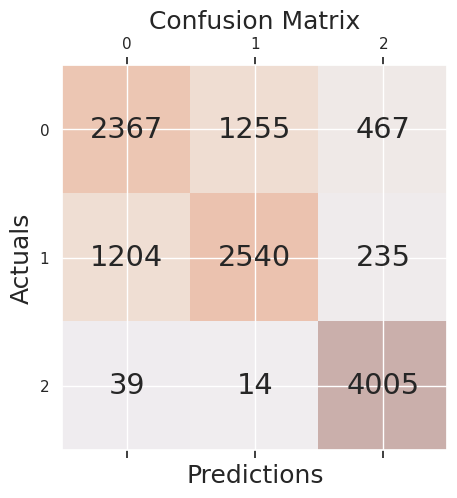

In [110]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cmat, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cmat.shape[0]):
    for j in range(cmat.shape[1]):
        ax.text(x=j, y=i,s=cmat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [111]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(12126, 3)

In [112]:
label_binarizer.transform(["Top"])

array([[0, 0, 1]])

In [113]:
class_of_interest = "Top"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

2

In [114]:
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

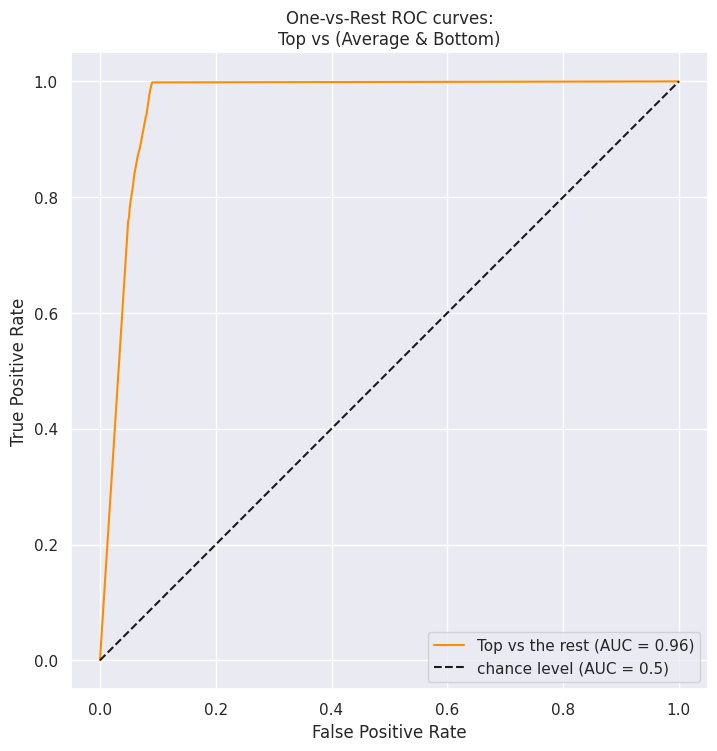

In [115]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nTop vs (Average & Bottom)")
plt.legend()
plt.show()

# MUSIC RECOMMENDATION SYSTEM

In [116]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [117]:
df8['feature_extract'] = df8['acousticness'].astype(str) + ' ' + df8['danceability'].astype(str) + ' ' + df8['duration_ms'].astype(str) + ' ' + df8['instrumentalness'].astype(str) + ' ' + df8['liveness'].astype(str) + ' ' +  df8['speechiness'].astype(str) + ' ' +  df8['tempo'].astype(str) + ' ' +  df8['valence'].astype(str)+ ' ' +  df8['track_genre']+ ' '+ df8['popularity'].astype(str)
df8['feature_extract'] = df8['feature_extract'].fillna('')

In [118]:
# Create bag of words
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(df8['feature_extract'])

In [119]:
# Convert bag of words to TF-IDF
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(bow)

In [120]:
# Apply latent semantic analysis
lsa = TruncatedSVD(n_components=100, algorithm='arpack')
lsa.fit(tfidf)

TruncatedSVD(algorithm='arpack', n_components=100)

In [121]:
pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [122]:
import time
from memory_profiler import memory_usage

# Remove unnecessary columns from df8
df8 = df8[['track_name', 'feature_extract']]

# Prompt the user to input a song name and handle errors
while True:
    song_input = input("Enter a song name: ")
    if song_input in df8['track_name'].values:
        break
    else:
        print("Invalid song name. Please try again.")

# Find the index of the input song
song_index = df8[df8['track_name'] == song_input].index[0]

# Compute the cosine similarities between the input song and others
start_time = time.time()
similarity_scores = cosine_similarity(tfidf[song_index], tfidf)
end_time = time.time()

# Get the top 10 most similar songs
similar_songs = list(enumerate(similarity_scores[0]))
sorted_similar_songs = sorted(similar_songs, key=lambda x: x[1], reverse=True)[1:11]

# Print the top 10 similar songs
for i, score in sorted_similar_songs:
    print("{}: {}".format(i, df8.loc[i, 'track_name']))

# Measure the execution time and memory usage
execution_time = end_time - start_time
memory_usage = max(memory_usage())
print("Execution time: {:.2f} seconds".format(execution_time))
print("Memory usage: {:.2f} MiB".format(memory_usage))

Enter a song name: Hold On
38178: My Boy
37224: Eu Sou Perfeito (Soldier Boy)
21735: Solus
681: Wind in Your Sails
208: Almost Lover
1348: Can't Stop
24862: Waves - Robin Schulz Radio Edit
531: So Are We
45751: Seyre Dursun Aşk - Akustik
118: get better
Execution time: 0.06 seconds
Memory usage: 844.46 MiB
